In [1]:
!pip3 install tensorflow-text==2.4.1

# import tensorflow as tf
# print(tf.__version__)

import tensorflow as tf
%tensorflow_version 2.x
# import tensorflow as tf
!pip3 install transformers
import os
import shutil
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import spearmanr
from math import floor, ceil
import pickle
# import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Dropout, Activation, Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import shutil



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.4 MB 4.7 MB/s 
     |████████████████████████████████| 394.5 MB 43 kB/s 
     |████████████████████████████████| 3.8 MB 45.6 MB/s 
     |████████████████████████████████| 132 kB 70.7 MB/s 
     |████████████████████████████████| 462 kB 67.4 MB/s 
     |████████████████████████████████| 14.8 MB 49.8 MB/s 
     |████████████████████████████████| 2.9 MB 48.7 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68726 sha256=a4a0212a9239f94801390caa0cfd4dde2a8a5e03aa5df17b04731b78090d272a
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attem

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.9 MB/s 
     |████████████████████████████████| 596 kB 69.1 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
#---------Data Read & Transformation---------
#Data Reading for Davidson Dataset
nRowsRead = None # specify 'None' to read complete file
df0 = pd.read_csv('/content/sample_data/labeled_data.csv', delimiter=',', nrows = nRowsRead)
nRow, nCol = df0.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

#Doing Transformation
c=df0['class']
df0.rename(columns={'tweet' : 'text',
                   'class' : 'category'}, 
                    inplace=True)
a=df0['text']
b=df0['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})
df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'}, 
                    inplace=True)

hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

#Splitting Dataset
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,    
)

X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

df_train = df.loc[df["data_type"]=="train"]
df_val = df.loc[df["data_type"]=="val"]
df_test = df.loc[df["data_type"]=="test"]

There are 24783 rows and 7 columns
Examples:
    Total: 24783
    hate: 1430 (5.77% of total)

Examples:
    Total: 24783
    Ofensive: 19190 (77.43% of total)

Examples:
    Total: 24783
    Neither: 4163 (16.80% of total)



In [3]:



#--------- Choosing Transfomer Model ---------
#creating tensors
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)

In [4]:
#Reading bert_en_uncased_L-2_H-128_A-2 in this file to fine tune

bert_model_name = 'electra_base'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

In [5]:
map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}


In [6]:
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

weight_for_0 = (1 / hate)*(total)/3.0 
weight_for_1 = (1 / ofensive)*(total)/3.0
weight_for_2 = (1 / neither)*(total)/3.0

#defining classweight to give into the models
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

BERT model selected           : https://tfhub.dev/google/electra_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
Weight for class 0: 5.78
Weight for class 1: 0.43
Weight for class 2: 1.98


In [7]:
#Defining Model Architecture
def CNN_model():
    #Trasnformer Encoding before feeding to CNN
    text_in = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocess_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_in = preprocess_layer(text_in)
    encode = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encode(encoder_in)
    network_layer= sequence_output = outputs["sequence_output"]
    # 2 CNNLayers
    network_layer = tf.keras.layers.Conv1D(32, (2), activation='relu')(network_layer) #CNN Layer 1
    network_layer = tf.keras.layers.Conv1D(64, (2), activation='relu')(network_layer) #CNN Layer 2
    network_layer = tf.keras.layers.GlobalMaxPool1D()(network_layer) #Global Maxpooling Layer
    network_layer = tf.keras.layers.Dense(256, activation="relu")(network_layer) #DenseLayer 
    network_layer = tf.keras.layers.Dropout(0.1)(network_layer) #Dropout Layer
    network_layer = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(network_layer) #ClassificationLayer
    return tf.keras.Model(text_in, network_layer)

#building model
cnn_model = CNN_model()

In [8]:
#defining loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#importing latest tfmodel here to avoid package conflicts
!pip install tf-models-official
from official.nlp import optimization

#fine tuning and Training models
epochs_count = 20#defining_epochs_count
steps_each_epoch = tf.data.experimental.cardinality(train_ds).numpy()#steps_per_epoch
number_of_training_steps = steps_each_epoch * epochs_count#defining_Training_steps
number_of_warmup_steps = int(0.1*number_of_training_steps)#defining_warmup_steps
init_lr = 3e-5 #deifning learning rate

#creating_optimiser
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=number_of_training_steps,
                                          num_warmup_steps=number_of_warmup_steps,
                                          optimizer_type='adamw')
#model compiling
cnn_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))


print(f'Training model with {tfhub_handle_encoder}')
#training_model
cnn_history = cnn_model.fit(x=train_ds,
                            validation_data=val_ds,
                            epochs=epochs_count,
                            class_weight=class_weight)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.8 MB/s 
     |████████████████████████████████| 352 kB 72.4 MB/s 
     |████████████████████████████████| 99 kB 11.7 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 15.7 MB 46.1 MB/s 
     |████████████████████████████████| 116 kB 72.6 MB/s 
     |████████████████████████████████| 511.7 MB 6.3 kB/s 
     |████████████████████████████████| 636 kB 39.3 MB/s 
     |████████████████████████████████| 238 kB 68.1 MB/s 
     |████████████████████████████████| 1.3 MB 67.9 MB/s 
     |████████████████████████████████| 4.6 MB 54.7 MB/s 
     |████████████████████████████████| 1.1 MB 70.0 MB/s 
     |████████████████████████████████| 1.6 MB 43.6 MB/s 
     |████████████████████████████████| 438 kB 65.9 MB/s 
     |████████████████████████████████| 5.8 MB 50.9 MB/s 
     |███████████████████████████

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate 

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
628/628 [==============================] - ETA: 0s - loss: 1.0722 - accuracy: 0.2931

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
628/628 [==============================] - 686s 1s/step - loss: 1.0720 - accuracy: 0.2935 - val_loss: 0.5258 - val_accuracy: 0.8238
Epoch 2/20
628/628 [==============================] - 660s 1s/step - loss: 0.5331 - accuracy: 0.8540 - val_loss: 0.4064 - val_accuracy: 0.8292
Epoch 3/20
628/628 [==============================] - 659s 1s/step - loss: 0.4758 - accuracy: 0.8829 - val_loss: 0.4303 - val_accuracy: 0.8445
Epoch 4/20
628/628 [==============================] - 660s 1s/step - loss: 0.3990 - accuracy: 0.8838 - val_loss: 0.3207 - val_accuracy: 0.8723
Epoch 5/20
628/628 [==============================] - 658s 1s/step - loss: 0.3346 - accuracy: 0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


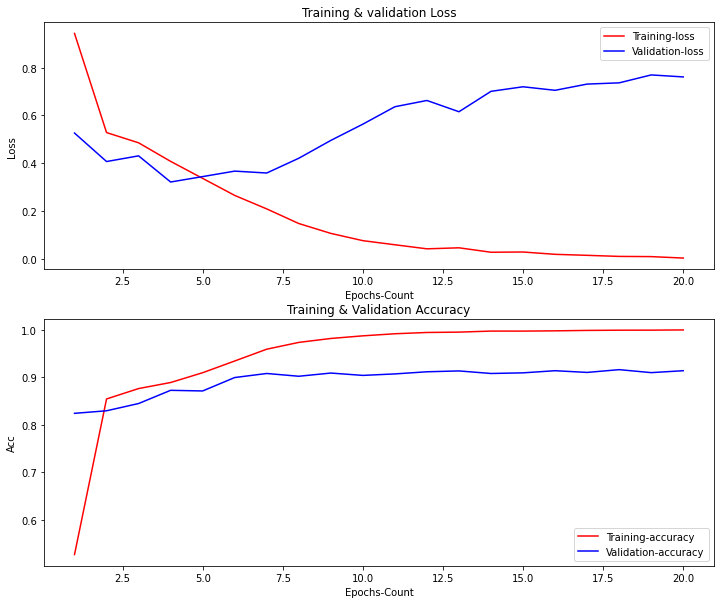

In [9]:
#creating graphs for accuracy and loss
#fining_values
history_dict = cnn_history.history
print(history_dict.keys())
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

#defining_figures
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()
#1st_figure
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training-loss')#training_loss
plt.plot(epochs, val_loss, 'b', label='Validation-loss')#validation_loss
plt.title('Training & validation Loss')
plt.xlabel('Epochs-Count')
plt.ylabel('Loss')
plt.legend()
#2nd_Figure
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training-accuracy')#training_accuracy
plt.plot(epochs, val_acc, 'b', label='Validation-accuracy')#validation_accuracy
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs-Count')
plt.ylabel('Acc')
plt.legend(loc='lower right')


In [10]:
#predicting on test dataset
text = []
test_labels = []
predictions = []
for text, label in test_ds.take(-1):
  text = text.numpy()#reading_text
  test_labels.append(label.numpy())#reading_text_label
  predictions.append(cnn_model.predict(text))#predicting

from itertools import chain
flatten_list = list(chain.from_iterable(predictions))

y_pred = np.argmax(flatten_list, axis=-1)#predicted_test_labels
y_test = np.array(list(chain.from_iterable(test_labels)))#true_test_labels

print(classification_report(y_test, y_pred))#priting_classfication_report
print(confusion_matrix(y_test, y_pred)) #priting_confusion_matrix


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.46      0.44      0.45       143
           1       0.94      0.95      0.94      1920
           2       0.92      0.89      0.90       416

    accuracy                           0.91      2479
   macro avg       0.77      0.76      0.77      2479
weighted avg       0.91      0.91      0.91      2479

[[  63   75    5]
 [  70 1821   29]
 [   3   42  371]]


In [13]:
user_input = ["I cannot tolerate how these bitches conspire against each other", "You are welcome to come to my country","I hate black people"]
user_input_prediction = cnn_model.predict(user_input)

result = []
for values in user_input_prediction:
   max = -1
   type_comment = -1
   for index,value in enumerate(values): 
      if (value > max):
         max = value
         type_comment = index
   result.append(type_comment) 
for speech, output in zip(user_input, result):
   print(f'{speech[:100]} -> {output}')

I cannot tolerate how these bitches conspire against each other -> 1
You are welcome to come to my country -> 2
I hate black people -> 0


In [14]:
#building MLP archictecture
def create_MLP_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    #input layer    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    #preprocessing layer 
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    #giving input to bert model from the pre processed layer
    encoder_inputs = preprocessing_layer(text_input)
    #selecting the encoder
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    #collecting the output of the bert encoder
    outputs = encoder(encoder_inputs)
    #collecting the pooled outputs
    net = outputs['pooled_output']
    #feeding the output to the multilayer perception
    #1 DENSE LAYER
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    #1 DROPUT LAYER
    net = tf.keras.layers.Dropout(0.2)(net)
    #1 OUTPUT LAYER WITH SOFTMAX
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier', bias_initializer=output_bias)(net)
    return tf.keras.Model(text_input, net)

mlp_model = create_MLP_model()



In [15]:
#importing latest tfmodel here to avoid package conflicts
!pip install tf-models-official
from official.nlp import optimization

#fine tuning and Training models
epochs_count = 20 #defining_epochs_count
steps_each_epoch = tf.data.experimental.cardinality(train_ds).numpy() #steps_per_epoch
number_of_training_steps = steps_each_epoch * epochs_count #defining_Training_steps
number_of_warmup_steps = int(0.1*number_of_training_steps) #defining_warmup_steps
init_lr = 3e-5 #deifning learning rate

#creating_optimiser
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=number_of_training_steps,
                                          num_warmup_steps=number_of_warmup_steps,
                                          optimizer_type='adamw')
#model compiling
mlp_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))


print(f'Training model with {tfhub_handle_encoder}')
#training_model
mlp_history = mlp_model.fit(x=train_ds,
                            validation_data=val_ds,
                            epochs=epochs_count,
                            class_weight=class_weight)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
628/628 [==============================] - ETA: 0s - loss: 1.0612 - accuracy: 0.5861

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
628/628 [==============================] - 641s 998ms/step - loss: 1.0609 - accuracy: 0.5862 - val_loss: 0.8105 - val_accuracy: 0.6468
Epoch 2/20
628/628 [==============================] - 624s 994ms/step - loss: 0.4996 - accuracy: 0.8435 - val_loss: 0.6513 - val_accuracy: 0.7333
Epoch 3/20
628/628 [==============================] - 623s 993ms/step - loss: 0.4488 - accuracy: 0.8720 - val_loss: 0.2716 - val_accuracy: 0.9113
Epoch 4/20
628/628 [==============================] - 624s 994ms/step - loss: 0.3576 - accuracy: 0.9000 - val_loss: 0.3568 - val_accuracy: 0.8861
Epoch 5/20
628/628 [==============================] - 624s 993ms/step - loss: 0.2750

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


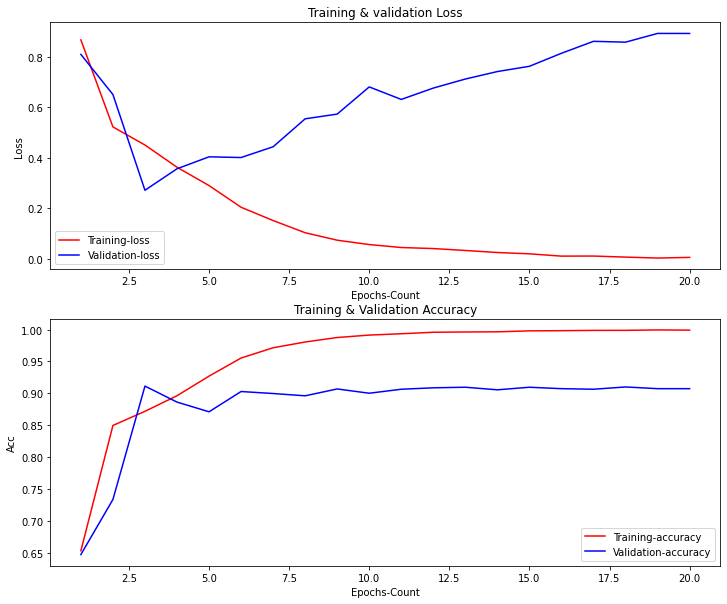

In [16]:
#creating graphs for accuracy and loss
#fining_values
history_dict = mlp_history.history
print(history_dict.keys())
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

#defining_figures
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()
#1st_figure
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training-loss')#training_loss
plt.plot(epochs, val_loss, 'b', label='Validation-loss')#validation_loss
plt.title('Training & validation Loss')
plt.xlabel('Epochs-Count')
plt.ylabel('Loss')
plt.legend()
#2nd_Figure
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training-accuracy')#training_accuracy
plt.plot(epochs, val_acc, 'b', label='Validation-accuracy')#validation_accuracy
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs-Count')
plt.ylabel('Acc')
plt.legend(loc='lower right')

In [17]:

#predicting
text = []
test_label = []
predictions = []

for text, label in test_ds.take(-1):
  text = text.numpy()#reading_text
  test_label.append(label.numpy())#reading_text_label
  predictions.append(mlp_model.predict(text))#predicting

from itertools import chain
flatten_list = list(chain.from_iterable(predictions))

y_pred = np.argmax(flatten_list, axis=-1)
y_test = np.array(list(chain.from_iterable(test_label)))

print(classification_report(y_test, y_pred))#priting_classfication_report
print(confusion_matrix(y_test, y_pred)) #priting_confusion_matrix

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.42      0.36      0.39       143
           1       0.93      0.95      0.94      1920
           2       0.92      0.88      0.90       416

    accuracy                           0.90      2479
   macro avg       0.76      0.73      0.74      2479
weighted avg       0.90      0.90      0.90      2479

[[  52   86    5]
 [  67 1825   28]
 [   5   47  364]]


In [18]:
def MLP_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    #input layer    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    #preprocessing layer 
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    #giving input to bert model from the pre processed layer
    encoder_inputs = preprocessing_layer(text_input)
    #selecting the encoder
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    #collecting the output of the bert encoder
    outputs = encoder(encoder_inputs)
    #collecting the pooled outputs
    net = outputs['pooled_output']
    #feeding the output to the multilayer perception
    #1 DENSE LAYER
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    #1 DROPUT LAYER
    net = tf.keras.layers.Dropout(0.2)(net)
    #1 OUTPUT LAYER WITH SOFTMAX
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier', bias_initializer=output_bias)(net)
    return tf.keras.Model(text_input, net)

In [19]:
#Defining Model Architecture
def CNN_model():
    #Trasnformer Encoding before feeding to CNN
    text_in = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocess_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_in = preprocess_layer(text_in)
    encode = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encode(encoder_in)
    network_layer= sequence_output = outputs["sequence_output"]
    # 2 CNNLayers
    network_layer = tf.keras.layers.Conv1D(32, (2), activation='relu')(network_layer) #CNN Layer 1
    network_layer = tf.keras.layers.Conv1D(64, (2), activation='relu')(network_layer) #CNN Layer 2
    network_layer = tf.keras.layers.GlobalMaxPool1D()(network_layer) #Global Maxpooling Layer
    network_layer = tf.keras.layers.Dense(256, activation="relu")(network_layer) #DenseLayer 
    network_layer = tf.keras.layers.Dropout(0.1)(network_layer) #Dropout Layer
    network_layer = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(network_layer) #ClassificationLayer
    return tf.keras.Model(text_input, network_layer)



In [21]:
user_input = ["I hate all the bitches who do not come in time to office", "You are welcome to come to my country","I hate black people"]
user_input_prediction = mlp_model.predict(user_input)

result = []
for values in user_input_prediction:
   max = -1
   type_comment = -1
   for index,value in enumerate(values): 
      if (value > max):
         max = value
         type_comment = index
   result.append(type_comment) 
for speech, output in zip(user_input, result):
   print(f'{speech[:100]} -> {output}')

I hate all the bitches who do not come in time to office -> 1
You are welcome to come to my country -> 2
I hate black people -> 0


Note: Used some slang languages as part of custom inputs to test the hate speech performance.